# 1. Setup

## 1.1: Importazione delle librerie necessarie

In [36]:
# Importiamo le librerie fondamentali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings


In [37]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [38]:
# Fissiamo un seme per la riproducibilità
np.random.seed(42)

## 1.2: Lettura dati

In [39]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [40]:
data_inizio = '2014-09-17'
data_fine = '2024-04-24'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


# 2. Generazione dei dataset con bullishness e volatilità specifiche

In [41]:
def calcola_distribuzione_variazioni(dati, n_bins):
    variazioni = dati['Price'].pct_change().dropna().reset_index(drop=True)
    distribuzione_variazioni = {}
    bins = np.linspace(np.min(variazioni), np.max(variazioni), n_bins + 1)
    
    for i in range(n_bins):
        bin_min = bins[i]
        bin_max = bins[i + 1]
        if i < n_bins - 1:
            variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni < bin_max)]
        else:
            variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni <= bin_max)]
        
        mean_value = np.mean(variazioni_bin)
        prob_value = len(variazioni_bin) / len(variazioni)
        
        if not np.isnan(mean_value):
            distribuzione_variazioni[f"[{bin_min:.4f}, {bin_max:.4f}]"] = (mean_value, prob_value)
    
    return distribuzione_variazioni

In [42]:
# Funzione per generare un dataset sintetico con una bullishness target
def genera_dataset_bullishness(L, punteggio_target, distribuzione_variazioni_positive, distribuzione_variazioni_negative):
    prezzi = [100]  # Prezzo iniziale
    for _ in range(L - 1):
        if np.random.rand() < (punteggio_target + 1) / 2:  # Converto bullishness da [-1, 1] a [0, 1]
            variazioni = [valore[0] for valore in distribuzione_variazioni_positive.values()]
            probabilita = [valore[1] for valore in distribuzione_variazioni_positive.values()]
        else:
            variazioni = [valore[0] for valore in distribuzione_variazioni_negative.values()]
            probabilita = [valore[1] for valore in distribuzione_variazioni_negative.values()]
        
        probabilita = probabilita / np.sum(probabilita)
        variazione = np.random.choice(variazioni, p=probabilita)
        prezzi.append(prezzi[-1] * (1 + variazione))
    
    return prezzi

In [43]:
# Funzione per correggere la volatilità del dataset
def correggi_volatilita(prezzi, target_volatilità):
    variazioni = np.diff(prezzi) / prezzi[:-1]
    std_attuale = np.std(np.abs(variazioni))  # Deviazione standard attuale
    print('Media dei moduli della variazioni del dataset solo bullishness da correggere:', np.mean(np.abs(variazioni)))
    fattore = target_volatilità / std_attuale  # Fattore moltiplicativo
    
    # Correggiamo le variazioni applicando il fattore
    nuove_variazioni = variazioni * fattore
    
    # Generiamo i nuovi prezzi applicando le variazioni corrette
    nuovi_prezzi = [prezzi[0]]
    for variazione in nuove_variazioni:
        nuovi_prezzi.append(nuovi_prezzi[-1] * (1 + variazione))
    
    return nuovi_prezzi

In [44]:
def genera_dataset_con_bullishness_e_volatilita(L, target_bullishness, target_volatilita, delta_1, delta_2, distribuzione_variazioni_positive, distribuzione_variazioni_negative):
    numero_tentativi = 0
    while True:
        numero_tentativi += 1
        # Genera dataset con la bullishness desiderata
        prezzi_iniziali = genera_dataset_bullishness(L, target_bullishness, distribuzione_variazioni_positive, distribuzione_variazioni_negative)
        
        # Calcola bullishness del dataset generato
        variazioni = np.diff(prezzi_iniziali) / prezzi_iniziali[:-1]
        bullishness_attuale = 2 * (np.sum(variazioni[variazioni > 0]) / np.sum(np.abs(variazioni))) - 1
        
        # Verifica se la bullishness è entro il range consentito
        if abs(bullishness_attuale - target_bullishness) <= delta_1:
            # Corregge la volatilità e ricalcola per verificarla
            prezzi_corretti = correggi_volatilita(prezzi_iniziali, target_volatilita)
            variazioni_corrette = np.diff(prezzi_corretti) / prezzi_corretti[:-1]
            volatilita_attuale = np.std(np.abs(variazioni_corrette))
            
            # Verifica se la volatilità è entro il range consentito
            if abs(volatilita_attuale - target_volatilita) <= delta_2:
                return prezzi_corretti, numero_tentativi

Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.026844134497076667
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.028236705450416084
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.024260039690462625
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.025166825214884742
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.023694400288090472
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.025872369281750445
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.025879005698604605
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02054948108295287
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02744099220690572
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02040833941290047
Media dei mod

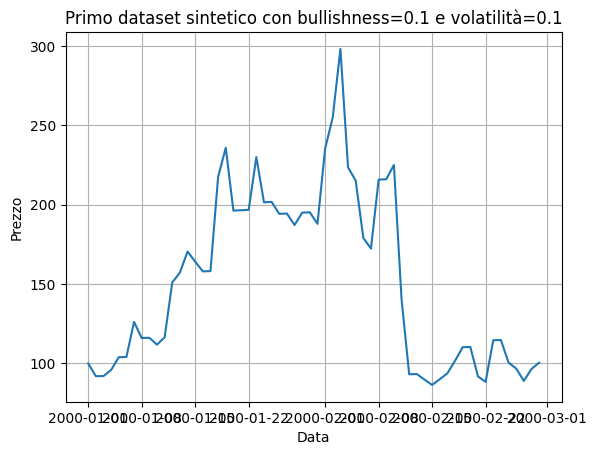

In [45]:
# Parametri di configurazione
n_datasets = 50  # Numero di dataset sintetici da generare
L = 60  # Durata del dataset in giorni
target_bullishness = 0.1  # Bullishness target (punteggio tra -1 e 1)
target_volatilita = 0.1  # Volatilità target: è la deviazione standard desiderata per i moduli delle variazioni percentuali giornaliere dei prezzi. 
                         # La volatilità riflette quanto i moduli delle variazioni percentuali giornaliere si discostano in media dal valore medio delle variazioni. 
                         # Poiché la massima variazione percentuale negativa possibile è -1 (caduta del 100%), il valore di target_volatilita deve essere abbastanza piccolo rispetto 
                         # alla media dei moduli delle variazioni percentuali del dataset generato inizialmente (che rispetta solo la bullishness).
n_bins = 50  # Numero di bin per la distribuzione delle variazioni
delta_1 = 0.01  # Errore massimo accettato per bullishness
delta_2 = 0.005  # Errore massimo accettato per volatilità

# Calcoliamo le distribuzioni positive e negative
distribuzione_variazioni = calcola_distribuzione_variazioni(dati, n_bins)
distribuzione_variazioni_positive = {k: v for k, v in distribuzione_variazioni.items() if v[0] > 0}
distribuzione_variazioni_negative = {k: v for k, v in distribuzione_variazioni.items() if v[0] < 0}

# Genera n_datasets dataset sintetici
datasets_sintetici = []
numero_tentativi_totale = 0  # Contatore tentativi

for _ in range(n_datasets):
    # Genera il dataset con la bullishness e volatilità richieste
    prezzi, numero_tentativi = genera_dataset_con_bullishness_e_volatilita(
        L, target_bullishness, target_volatilita, delta_1, delta_2,
        distribuzione_variazioni_positive, distribuzione_variazioni_negative
    )
    numero_tentativi_totale += numero_tentativi

    # Creiamo un DataFrame con Timestamp e Price
    dataset_df = pd.DataFrame({
        "Timestamp": pd.date_range(start='2000-01-01', periods=L),
        "Price": prezzi
    })
    datasets_sintetici.append(dataset_df)

# Stampa il numero totale di tentativi per creare i dataset
print('Numero totale di tentativi per creare i dataset:', numero_tentativi_totale)

# Visualizza il grafico del primo dataset sintetico
plt.plot(datasets_sintetici[0]["Timestamp"], datasets_sintetici[0]["Price"])
plt.title(f'Primo dataset sintetico con bullishness={target_bullishness} e volatilità={target_volatilita}')
plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.grid(True)
plt.show()

In [46]:
datasets_sintetici[0]

,Timestamp,Price
0,2000-01-01,100.000000
1,2000-01-02,91.954662
2,2000-01-03,92.071305
3,2000-01-04,95.890793
4,2000-01-05,103.953310
5,2000-01-06,104.085173
6,2000-01-07,126.182706
7,2000-01-08,116.030880
8,2000-01-09,116.178064
9,2000-01-10,111.838700


In [47]:
# Verifica delle deviazioni standard per ciascun dataset sintetico
for i, dataset in enumerate(datasets_sintetici):
    # Estrae i prezzi dal DataFrame
    prezzi = dataset["Price"].values
    
    # Calcola le variazioni percentuali giornaliere
    variazioni = np.diff(prezzi) / prezzi[:-1]
    
    # Calcola la volatilità (deviazione standard dei moduli delle variazioni percentuali)
    volatilita_attuale = np.std(np.abs(variazioni))
    
    # Stampa la volatilità attuale e la differenza dal target
    print(f'Dataset {i+1}: Volatilità = {volatilita_attuale:.5f}, Differenza dal target = {abs(volatilita_attuale - target_volatilita):.5f}')
    
    # Controlla se la volatilità è fuori dal range consentito
    if abs(volatilita_attuale - target_volatilita) > delta_2:
        print(f'Attenzione: La volatilità del dataset {i+1} è fuori dal range consentito!\n')

Dataset 1: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 2: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 3: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 4: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 5: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 6: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 7: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 8: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 9: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 10: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 11: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 12: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 13: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 14: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 15: Volatilità = 0.10000, Differenza dal target = 0.00000
Dataset 16: Volatil

# 3. Applicazione della strategia di trading a ciascun dataset

In [48]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti, A, B):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    elif coefficienti == 'custom_exp':
        return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [49]:
def trading_perc_senza_micro_variazioni_velocizzato(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti,
     compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita,
     compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento,
     soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine, liquidità_iniziale, bitcoin_iniziali):
    

    # Parametri iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

    # Calcolo variazioni giornaliere
    dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

    # Inizializza la lista delle transazioni
    transazioni = []

    # Variabili per tenere traccia degli acquisti consecutivi
    acquisti_consecutivi = []
    quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

    liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

    ultimo_prezzo_acquisto = None
    ultimo_prezzo_vendita = None
    ultima_azione = None
    azione = None


    # Simulazione del trading giorno per giorno
    for i in range(1, len(dati)):
        # data_odierna = dati['Timestamp'].iloc[i]
        prezzo_attuale = dati['Price'].iloc[i]
        variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
        if perc_relativa:
            if finestra_minimo <= i:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

            else:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

            if finestra_massimo <= i:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

            else:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
        
        # Calcola i prezzi di riferimento discesa e salita
        timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
        timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
        # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
        # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

        # Scegli il prezzo di riferimento più recente (se esiste)
        prezzo_riferimento = None
        if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
            if timestamp_riferimento_discesa > timestamp_riferimento_salita:
                prezzo_riferimento = prezzo_riferimento_discesa
                tipo_riferimento = 'discesa'
            else:
                prezzo_riferimento = prezzo_riferimento_salita
                tipo_riferimento = 'salita'
        elif prezzo_riferimento_discesa is not None:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        elif prezzo_riferimento_salita is not None:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'

        # Se nessun riferimento è disponibile, passa al giorno successivo
        if prezzo_riferimento is None:
            continue

        # Variabili per tracciare l'azione e la transazione
        azione = '-'
        # percentuale_liquidità_usata = 0
        # percentuale_bitcoin_usata = 0
        # percentuale_liquidità_usata_rispetto_rif = 0
        # percentuale_bitcoin_usata_rispetto_rif = 0
        # euro_spesi_o_ricavati = 0
        # bitcoin_acquistati_o_venduti = 0

        # Logica di acquisto o vendita in base al riferimento più recente
        if tipo_riferimento == 'discesa':  # Logica di acquisto
            if not perc_relativa:
                if inverti_riferimento_acquisto:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
            else:
                den = prezzo_riferimento_discesa - minimo_ultimi_giorni
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
                    num = prezzo_riferimento_discesa - prezzo_attuale
                    variazione_percentuale = num / den
                    if not nuovi_min_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_acquisto:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
                else:
                    variazione_percentuale = 0


            percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
            liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
            euro_da_spendere = liquidità_da_usare * percentuale_acquisto

            if euro_da_spendere > liquidità:
                if compra_pure:
                    euro_da_spendere = liquidità  # Usa tutto
                else:
                    euro_da_spendere = 0  # Non fare niente

            if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
                # percentuale_liquidità_usata = euro_da_spendere / liquidità
                bitcoin_acquistati = euro_da_spendere / prezzo_attuale
                liquidità -= euro_da_spendere
                bitcoin += bitcoin_acquistati
                azione = 'Acquisto'
                ultima_azione = azione
                # percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
                # euro_spesi_o_ricavati = euro_da_spendere
                # bitcoin_acquistati_o_venduti = bitcoin_acquistati
                
                # Aggiungi questo acquisto alla lista degli acquisti consecutivi
                acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
                quantità_euro_totale += euro_da_spendere
                ultimo_prezzo_acquisto = prezzo_attuale

        elif tipo_riferimento == 'salita':  # Logica di vendita
            if not perc_relativa:
                if inverti_riferimento_vendita:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
            else:
                den = massimo_ultimi_giorni - prezzo_riferimento_salita
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
                    num = prezzo_attuale - prezzo_riferimento_salita
                    variazione_percentuale = num / den
                    if not nuovi_max_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_vendita:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
                else:
                    variazione_percentuale = 0

            percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
            bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
            bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


            # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
            if acquisti_consecutivi:
                # Calcolo della media pesata dei prezzi di acquisto
                somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
                media_pesata_acquisti = somma_pesata / quantità_euro_totale

                # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
                if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                    # Se non soddisfa la soglia di vendita, non fare niente
                    bitcoin_da_vendere = 0

            if bitcoin_da_vendere > bitcoin:
                if vendi_pure:
                    bitcoin_da_vendere = bitcoin  # Vendi tutto
                else:
                    bitcoin_da_vendere = 0  # Non fare niente

            if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
                # percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
                euro_ricavati = bitcoin_da_vendere * prezzo_attuale
                bitcoin -= bitcoin_da_vendere
                liquidità += euro_ricavati
                azione = 'Vendita'
                ultima_azione = azione
                # percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
                # euro_spesi_o_ricavati = euro_ricavati
                # bitcoin_acquistati_o_venduti = bitcoin_da_vendere

                # Reset degli acquisti consecutivi dopo una vendita
                acquisti_consecutivi = []
                quantità_euro_totale = 0
                ultimo_prezzo_vendita = prezzo_attuale


        # Aggiorna il valore totale del portafoglio
        valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

        # variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
        # variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

        # Salva la transazione nella lista
        nuova_transazione = {
            # 'data': data_odierna,
            'prezzo': prezzo_attuale,
            # 'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
            # 'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
            # 'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
            # 'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
            # 'timestamp_riferimento_salita': timestamp_riferimento_salita,
            # 'prezzo_riferimento_salita': prezzo_riferimento_salita,
            # 'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
            # 'azione': azione,
            # 'percentuale_liquidità_usata': percentuale_liquidità_usata,
            # 'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
            # 'quantità_euro': euro_spesi_o_ricavati,
            # 'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
            # 'liquidità': liquidità,
            'bitcoin': bitcoin,
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        transazioni.append(nuova_transazione)

    # Crea il DataFrame delle transazioni alla fine
    df_transazioni = pd.DataFrame(transazioni)

    return df_transazioni

In [50]:
# Creazione del dizionario 'parametri'
parametri_variabili = {
    "inverti_riferimento_acquisto": True,
    "inverti_riferimento_vendita": True,
    "acquisto_rispetto_liquidità_iniziale": True,
    "vendita_rispetto_massimo_btc_posseduti": True,
    "compra_pure": True,
    "vendi_pure": True,
    "soglia_vendita": 0,
    "A_a": 10,
    "B_a": 0.001,
    "A_v": 10,
    "B_v": 0.001,
    "coefficienti_acquisto": 'custom_exp',
    "coefficienti_vendita": 'custom_exp',
    "compra_solo_in_discesa": True,
    "vendi_solo_in_salita": False,
    "soglia_acquisto_rispetto_riferimento": 0,
    "soglia_vendita_rispetto_riferimento": 0,
    "soglia_calcolo_variazioni_discesa": 0.05,
    "soglia_calcolo_variazioni_salita": 0.05,
    "perc_relativa": False,
    "finestra_minimo": 30,
    "finestra_massimo": 30,
    "nuovi_min_all_in": False,
    "nuovi_max_all_in": False,
    "soglia_acquisti_vicini": 0.05,
    "soglia_vendite_vicine": 0.05
}

parametri_fissi = {
    "liquidità_iniziale": 1000,
    "bitcoin_iniziali": 0
}

# Applicazione della strategia a ciascun dataset
portfolio_results = []
for dataset in datasets_sintetici:
    df_transazioni = trading_perc_senza_micro_variazioni_velocizzato(dataset, **parametri_variabili, **parametri_fissi)
    portfolio_results.append(df_transazioni["valore_totale_portafoglio"])

In [51]:
portfolio_results[0]

0     1000.000000
1     1000.000000
2     1000.000001
3     1000.000003
4     1000.000003
5     1000.000010
6     1000.000007
7     1000.000007
8     1000.000005
9     1000.000007
10    1000.000025
11    1000.000028
12    1000.000035
13    1000.000032
14    1000.000028
15    1000.000028
16    1000.000059
17    1000.000068
18    1000.000048
19    1000.000190
20    1000.000333
21    1000.019321
22    1000.003043
23    1000.003189
24     999.998882
25     999.999022
26     999.994871
27     999.999310
28     999.999451
29     999.995283
30    1000.022348
31    1000.033654
32    1000.058269
33    1000.015631
34     999.381307
35     996.635977
36     960.825615
37    1193.382630
38    1194.848362
39    1242.843941
40     790.506262
41     524.205903
42     524.870850
43     505.266411
44     486.394218
45     506.571806
46     527.586442
47     571.946018
48     620.035356
49     620.821861
50     516.569876
51     497.275487
52     644.668055
53     645.485806
54     565.549538
55     544

# 4. Calcolo del rendimento e analisi del range dei rendimenti (epsilon)

Bullishness target: 0.1 con delta_1 accettabile di 0.01
Bullishness media: 0.10013, Differenza max-min bullishness: 0.01980

Volatilità target: 0.1 con delta_2 accettabile di 0.005
Volatilità media: 0.10000, Differenza max-min volatilità: 0.00000

Rendimento medio: 1.34906 con epsilon di 2.1422839528968707 - 0.32861853046515116 = 1.81367


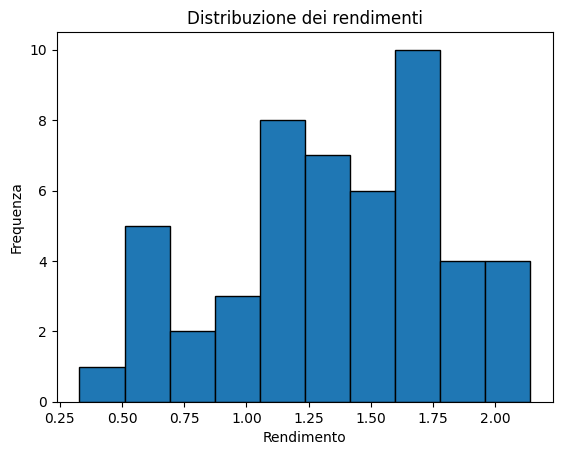

In [55]:
# Funzione per calcolare il rendimento del dataset
def calculate_return(portfolio_values):
    return portfolio_values.iloc[-1] / portfolio_values.iloc[0]

# Funzione per calcolare bullishness di un dataset
def calculate_bullishness(prices):
    variazioni = np.diff(prices) / prices[:-1]
    bullishness = 2 * (np.sum(variazioni[variazioni > 0]) / np.sum(np.abs(variazioni))) - 1
    return bullishness

# Funzione per calcolare volatilità di un dataset
def calculate_volatility(prices):
    variazioni = np.diff(prices) / prices[:-1]
    return np.std(np.abs(variazioni))

# Liste per bullishness e volatilità
bullishness_list = []
volatility_list = []

# Calcoliamo bullishness e volatilità per ciascun dataset sintetico
for dataset in datasets_sintetici:
    prezzi = dataset["Price"].values
    bullishness_list.append(calculate_bullishness(prezzi))
    volatility_list.append(calculate_volatility(prezzi))

# Calcoliamo il rendimento per ciascun dataset

returns = [calculate_return(portfolio) for portfolio in portfolio_results]

# Calcoliamo le statistiche richieste
bullishness_mean = np.mean(bullishness_list)
bullishness_delta = max(bullishness_list) - min(bullishness_list)

volatility_mean = np.mean(volatility_list)
volatility_delta = max(volatility_list) - min(volatility_list)

epsilon = max(returns) - min(returns)  # Differenza tra rendimento massimo e minimo

# Stampa dei risultati
print(f"Bullishness target: {target_bullishness} con delta_1 accettabile di {delta_1}")
print(f"Bullishness media: {bullishness_mean:.5f}, Differenza max-min bullishness: {bullishness_delta:.5f}\n")

print(f"Volatilità target: {target_volatilita} con delta_2 accettabile di {delta_2}")
print(f"Volatilità media: {volatility_mean:.5f}, Differenza max-min volatilità: {volatility_delta:.5f}\n")

print(f"Rendimento medio: {np.mean(returns):.5f} con epsilon di {max(returns)} - {min(returns)} = {epsilon:.5f}")

# Visualizziamo i rendimenti
plt.hist(returns, bins=10, edgecolor='black')
plt.title('Distribuzione dei rendimenti')
plt.xlabel('Rendimento')
plt.ylabel('Frequenza')
plt.show()

# 5. Conclusione: Verifica a delta_1 e delta_2 minori corrispondono epsilon minori

Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.028038302463715248
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02648451833321917
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02485580459770404
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02161007177948582
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.027215352003942535
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.018043289463287423
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.030719192777871714
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.02313416193046148
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.022370697775768545
Media dei moduli della variazioni del dataset solo bullishness da correggere: 0.021164930164680282
Media dei modu

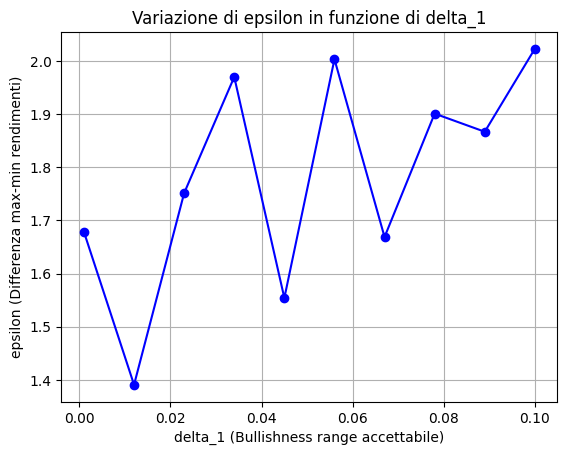

In [56]:
# Liste per memorizzare i valori di delta_1 e epsilon
delta_1_values = np.linspace(0.001, 0.1, 10)  # Valori di delta_1 da 0.001 a 0.1 con 10 step
epsilon_values = []

# Ciclo su diversi valori di delta_1
for delta_1 in delta_1_values:
    # Genera i dataset sintetici per ogni valore di delta_1
    datasets_sintetici = []
    for _ in range(n_datasets):
        prezzi, numero_tentativi = genera_dataset_con_bullishness_e_volatilita(
            L, target_bullishness, target_volatilita, delta_1, delta_2,
            distribuzione_variazioni_positive, distribuzione_variazioni_negative
        )
        dataset_df = pd.DataFrame({
            "Timestamp": pd.date_range(start='2000-01-01', periods=L),
            "Price": prezzi
        })
        datasets_sintetici.append(dataset_df)

    # Applica la strategia di trading a ciascun dataset sintetico
    portfolio_results = []
    for dataset in datasets_sintetici:
        df_transazioni = trading_perc_senza_micro_variazioni_velocizzato(dataset, **parametri_variabili, **parametri_fissi)
        portfolio_results.append(df_transazioni["valore_totale_portafoglio"])

    # Calcola il rendimento per ciascun dataset
    returns = [calculate_return(portfolio) for portfolio in portfolio_results]

    # Calcola epsilon, ovvero la differenza tra rendimento massimo e minimo
    epsilon = max(returns) - min(returns)
    epsilon_values.append(epsilon)

    # Stampa per il controllo
    print(f"Per delta_1 = {delta_1:.5f}, epsilon = {epsilon:.5f}")

# Visualizza il grafico di epsilon in funzione di delta_1
plt.plot(delta_1_values, epsilon_values, marker='o', linestyle='-', color='b')
plt.title('Variazione di epsilon in funzione di delta_1')
plt.xlabel('delta_1 (Bullishness range accettabile)')
plt.ylabel('epsilon (Differenza max-min rendimenti)')
plt.grid(True)
plt.show()

In [ ]:
# Conclusione: bullishness e volatilità non sono caratteristiche sufficienti affinchè la strategia scelta possa garantire che un rendimento sarà sempre basso o sempre alto per certe bullishness e volatilità del dataset in questione